## Creating a ConnectivityMatrix object of the Fly connectome

In this example we use available data to create a ConnectivityMatrix object of the fly connectome. This is based on Mehta et al: https://direct.mit.edu/netn/article/7/1/269/113338/Circuit-analysis-of-the-Drosophila-brain-using

The authors of that study made their data (and code) available on github:
https://github.com/k3t3n/FlyConn/tree/main

To begin, clone the repository linked above. In the next code cell, you will have to indicate its location where prompted.
Note that the data is formatted in .rds, an R-specific file format. The best way of reading it in python I found is through rpy2. This requires also the installation of R. If you find a better way of reading the data, please let us know.

We begin by setting up rpy2 and setting the data paths

## DISCLAIMER
Important: I am not an expert on this particular connectome. The code below is my interpretation of how the available data is formated, and I may have completely misunderstood it. This is meant to be an _example of some functionality_ of a python analysis package, _not a scientific exploration_ of a connectome. No one besides me has reviewed this example. 

Before using the results in this example for serious science, please double check everything!

In [1]:
import numpy
import pandas
import os

import conntility

from scipy import sparse
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from matplotlib import pyplot as plt


# INDICATE LOCATION OF THE FlyConn REPO YOU CLONED BELOW!
base_root = "../../FlyConn"

flyconn_root = os.path.join(base_root, "data")
fn_con = "A_str.rds"
fn_metadata = "fly_metadata.csv"

flyconn_root2 = os.path.join(base_root, "labels")
fn_acl = "ACl.rds"


pandas2ri.activate()

readRDS = robjects.r['readRDS']

 2023-06-07 01:59:21,373: cffi mode is CFFI_MODE.ANY
 2023-06-07 01:59:21,389: R home found: /usr/lib/R
 2023-06-07 01:59:21,502: R library path: /usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server
 2023-06-07 01:59:21,503: LD_LIBRARY_PATH: /usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server
 2023-06-07 01:59:21,507: Default options to initialize R: rpy2, --quiet, --no-save
 2023-06-07 01:59:21,671: R is already initialized. No need to initialize.


Next, we read the connectivity matrix. It is formated as a sparse matrix that is compatible with the scipy.sparse.csc_matrix representation.

In [2]:
df = readRDS(os.path.join(flyconn_root, fn_con))

def rs42sparse(df):
    idx = pandas2ri.rpy2py(df.slots['i'])
    p = pandas2ri.rpy2py(df.slots['p'])
    data = df.slots['x']
    shape = pandas2ri.rpy2py(df.slots["Dim"])
    
    labels = pandas2ri.rpy2py(df.slots["Dimnames"])
    assert numpy.all(labels[0] == labels[1])
    
    return sparse.csc_matrix((data, idx, p), shape=shape), labels[0]

M, labels = rs42sparse(df)

 2023-06-07 01:59:22,477: R[write to console]: Loading required package: Matrix



Then we load annotations for the neurons. The first file contains basic information on neuron names, birthtime, etc. The second one also contains the main results of the publication listed above: connectomic-derived sub-network labels for all neurons!

In [3]:
nrn = pandas.read_csv(os.path.join(flyconn_root, fn_metadata)).set_index("Name")
nrn = nrn.loc[labels]

df = readRDS(os.path.join(flyconn_root2, fn_acl))
nrn_cl = pandas2ri.rpy2py(df).rename(columns={"neuron_name": "Name"}).set_index("Name")
nrn_cl = nrn_cl[["morpho", "community", "network", "spad", "type"]]
nrn_cl = nrn_cl.loc[labels]


display(pandas.concat([nrn, nrn_cl], axis=1).head())

,Index,Driver,Neurotransmitter,Birthtime,morpho,community,network,spad,type
Name,,,,,,,,,
104198-F-000000,1,104198-Gal4,unknown,embryo,0.0,OlfactoryRight,0.0,1.0,0
104198-F-000001,2,104198-Gal4,unknown,embryo,0.0,OlfactoryRight,0.0,1.0,0
104198-F-000003,3,104198-Gal4,unknown,embryo,0.0,OlfactoryRight,0.0,3.0,0
104198-F-000004,4,104198-Gal4,unknown,embryo,0.0,OlfactoryLeft,49.0,4.0,0
104198-F-000005,5,104198-Gal4,unknown,embryo,0.0,OlfactoryRight,38.0,3.0,0


We build a "ConnectivityMatrix" object from this.
Disclaimer: the ConnectivityMatrix assumes that the first dimension of "M" denotes the _source_ neuron and the second one the _target_ neuron. I am not sure the data is formated that way (unfortunately there is no standard on this).

If I got this wrong, let me know.

In [4]:
C = conntility.ConnectivityMatrix(M, vertex_properties=pandas.concat([nrn, nrn_cl], axis=1))

As a sanity check of my assumption that the first dimension is the source, I calculate the resulting weighted in- and outdegrees of the individual communities.

In [5]:
comm_counts = C.vertices["community"].value_counts().sort_index()  # Number of neuron in each community, for normalization
display(comm_counts)

comm_edges = C.edge_associated_vertex_properties("community")  # For each edge, its source and target community
comm_edges = pandas.concat([comm_edges, C.edges], axis=1)  # Concatenate the edge weight

indeg = comm_edges.groupby("col")["data"].sum() / comm_counts  # Total inputs per neuron
outdeg = comm_edges.groupby("row")["data"].sum() / comm_counts  # total outputs per neuron

display(outdeg - indeg)

community
Auditory          1588
Motor             1262
OlfactoryCore     2991
OlfactoryLeft     1184
OlfactoryRight    1247
PreMotor          3637
VisionLeft        3965
VisionRight       4028
Name: count, dtype: int64

row
Auditory          -72.942065
Motor             -50.210777
OlfactoryCore    -133.435640
OlfactoryLeft      40.802365
OlfactoryRight    198.817161
PreMotor           45.965906
VisionLeft         24.897856
VisionRight         4.014647
dtype: float64

Does it look like what you would expect given the overall sensory-motor flow? I am not a fly expert, so I don't know.


But here is some other things we can do.

Use the .index function to access subnetworks

In [6]:
C.index("Birthtime").eq("embryo").matrix

<2294x2294 sparse matrix of type '<class 'numpy.float64'>'
	with 59875 stored elements in COOrdinate format>

The .neighborhood functon returns a subnetwork of neurons that are connected to a specified neuron (or list of specified neurons).

In [7]:
C.neighborhood.get("104198-F-000005").array

array([[  0.,   0.,   0., ...,  13.,  13.,   4.],
       [  5.,   0.,   0., ...,  12.,   0.,  29.],
       [  2.,   6.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [358.,  37.,  46., ..., 349.,   0., 431.],
       [ 69.,   0.,   0., ..., 149., 202.,   0.]])

With .condense we can count the number of connections between groups of neurons.

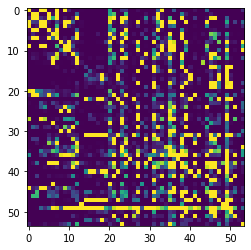

In [8]:
# NOTE: We first filter for the value of "network" (g)reater (t)han 0.
# Because 0 indicates neurons that are not part of any specific network, so we ignore them here.

plt.imshow(C.index("network").gt(0).condense("network").array, clim=[0, 1000])

We can then use .filter to restrict to edges stronger than a specified value (such as 500 here) to de-noisen the result.

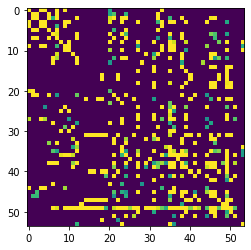

In [9]:
plt.imshow(C.index("network").gt(0).condense("network").filter("count").gt(500).array, clim=[0, 1000])

We can assess the modularity of the network with respect to the subnetworks of the publication.

In [10]:
C0 = C.index("network").gt(0)
mdlrty = C0.modularity("network")

print("Modularity of the subnetwork parcellation: {0}".format(mdlrty))

Modularity of the subnetwork parcellation: 0.11217645527841924


We can store the results for future loading.

In [11]:
C.to_h5("./data/Drosophila_Mehta.h5")